# Part 3: Writing your own Episode of House MD - 30%
![](https://upload.wikimedia.org/wikipedia/en/thumb/b/ba/HouseMD-s1-UK-DVD.jpg/250px-HouseMD-s1-UK-DVD.jpg)
![](https://upload.wikimedia.org/wikipedia/en/d/da/HouseMD-s4-US-DVD.jpg)
![](https://upload.wikimedia.org/wikipedia/en/1/16/House_S6_DVD.jpg)

connect to my google drive to get the dataset and save stuff

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## libraries to import


In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import string
import tensorflow as tf
import time
import random
import requests
import pickle

In [6]:
WORKDIR = "/content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/"

## function to load all the seasons 

In [7]:
def load_dataset(seasons=("season1","season2","season3","season4","season5","season6","season7","season8")):
    dfs = []
    for season in seasons:
        dfs.append(pd.read_csv(
            os.path.join(WORKDIR, '{}.csv'.format(season)), encoding="unicode_escape"))

    return pd.concat(dfs, keys=seasons).reset_index().rename(columns={'level_0': 'season',
                                                                      'level_1': 'line_num'})

## Build a model for each of the top three characters in the Series

### Need a Sequence generator to give batches of lines by the character to the Model when training

In [8]:
class LineGenerator(tf.keras.utils.Sequence):

    def __init__(self, data, batch_size,
                 tokenizer):
        self.batch_size = batch_size
        self.data = data
        self.tokenizer = tokenizer
        self.total_words = len(tokenizer.word_index) + 1
        self.data_sequence = []
        self.prepare_data()
        self.indices = np.arange(len(self.data_sequence))

    def prepare_data(self):
        for line in self.data:
            token_list = self.tokenizer.texts_to_sequences([line])[0]
            for i in range(1, len(token_list)):
                n_gram_sequence = token_list[:i + 1]
                self.data_sequence.append(n_gram_sequence)
        self.data_sequence = np.array(
            tf.keras.preprocessing.sequence.pad_sequences(self.data_sequence, maxlen=20, padding='pre',
                                                          truncating="pre"))

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, idx):
        inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_data = self.data_sequence[inds]
        X, y = batch_data[:, :-1], batch_data[:, -1]
        y = tf.keras.utils.to_categorical(y, num_classes=self.total_words)
        return X, y

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

### Another function to create a model for the characters dialogue 

The model will train by trying to predict the next word in the line give by the dataset for that character. A LSTM layer is used to optimize the search for patterns in the sequences.

In [14]:
def get_lines(df, character):
    return [x + "\n" for x in df.loc[df['name'] == character]["line"].tolist()]

def get_model(df, tokenizer, character):
    print("Getting model for", character)
    list_of_lines = get_lines(df, character=character)

    train_gen = LineGenerator(data=list_of_lines, batch_size=200, tokenizer=tokenizer)

    total_words = len(tokenizer.word_index) + 1

    model = tf.keras.models.Sequential()

    # Add Input Embedding Layer
    model.add(tf.keras.layers.Embedding(total_words, 10, input_length=19))

    # Add Hidden Layer 1 - LSTM Layer
    model.add(tf.keras.layers.LSTM(50))
    model.add(tf.keras.layers.Dropout(0.1))

    # Add Output Layer
    model.add(tf.keras.layers.Dense(total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam')

    print(model.summary())

    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(os.path.join(WORKDIR, "best_model_{}.h5".format(character)),
                                           mode='min', save_best_only=True, monitor='loss', verbose=1),
        tf.keras.callbacks.CSVLogger(os.path.join(WORKDIR, 'logger_{}.csv'.format(character)), append=True),
        tf.keras.callbacks.EarlyStopping(mode='min', monitor="loss", patience=5, verbose=1),
    ]

    model.fit(train_gen, epochs=200, callbacks=callbacks)

    model = tf.keras.models.load_model(os.path.join(WORKDIR, "best_model_{}.h5".format(character)))

    history = pd.read_csv(os.path.join(WORKDIR, 'logger_{}.csv'.format(character)))
    plt.figure(figsize=(12, 5))
    plt.plot(history['loss'])
    plt.title('Model loss ({})'.format(character))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    return model

## Run the training, using the top 3 character from HOUSE MD

House                                      20908
Foreman                                     6590
Chase                                       4989
Wilson                                      4874
Cameron                                     4150
                                           ...  
Cuddy [somewhat offended]                      1
Masters [with a quiet voice]                   1
Chase [not believing her]                      1
 Chase is down to his last possibility         1
 The whiteboard now lists                      1
Name: name, Length: 1420, dtype: int64
total words 60047
TOP 3 character: ['House', 'Foreman', 'Chase']
Getting model for House
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 19, 10)            600470    
                                                                 
 lstm_1 (LSTM)               (None, 50)        

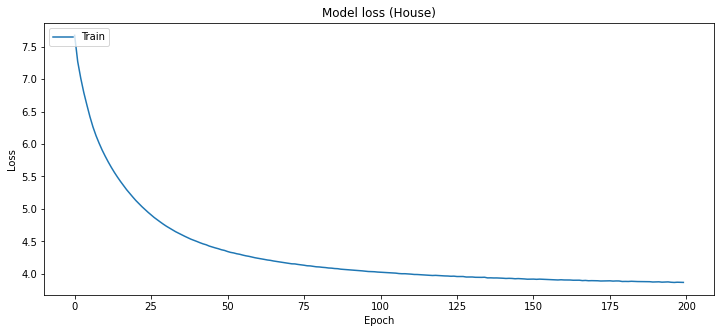

Getting model for Foreman
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 19, 10)            600470    
                                                                 
 lstm_2 (LSTM)               (None, 50)                12200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 60047)             3062397   
                                                                 
Total params: 3,675,067
Trainable params: 3,675,067
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
348/350 [============================>.] - ETA: 0s - loss: 8.1658
Epoch 1: loss improved from inf to 8.16222, saving model to /conten

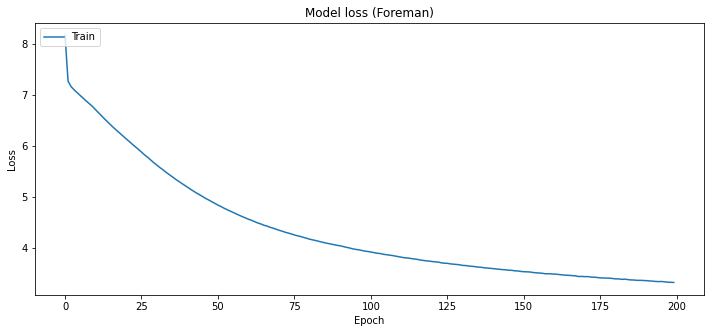

Getting model for Chase
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 19, 10)            600470    
                                                                 
 lstm_3 (LSTM)               (None, 50)                12200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 60047)             3062397   
                                                                 
Total params: 3,675,067
Trainable params: 3,675,067
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
256/258 [============================>.] - ETA: 0s - loss: 8.3760
Epoch 1: loss improved from inf to 8.37034, saving model to /content/

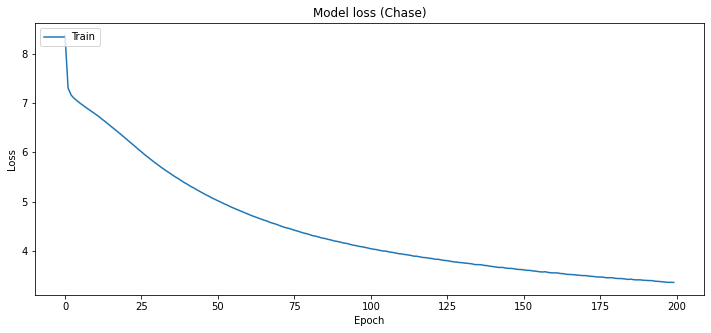

In [15]:
train_df = load_dataset()

# fit the tokenizer for all lines by everyone
all_lines = [x + "\n" for x in train_df["line"].tolist() if isinstance(x, str)]
print(train_df["name"].value_counts())

# we don't want to remove all symbols from the text, brackets and newlines could be useful
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='#$%&*+-/:;<=>@[\\]^_`{|}~\t')
tokenizer.fit_on_texts(all_lines)

total_words = len(tokenizer.word_index) + 1 # total amount of words which we can integers for
print("total words", total_words)

# getting a list of the top 3 character by amount of lines spoken 
characters = train_df["name"].value_counts().index[:3].to_list() 
print("TOP 3 character:", characters)
character_models = []
for character in characters:
    model = get_model(train_df, tokenizer, character=character)
    character_models.append(model)


# also save the Tokenizer for generating real text and not just integers which we can't read

In [9]:
# saving
with open(os.path.join(WORKDIR, 'house_tokenizer.pickle'), 'wb') as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)


In [14]:
!du -h  /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/house_tokenizer.pickle

2.4M	/content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/house_tokenizer.pickle
